# Import data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sid321axn/beijing-multisite-airquality-data-set")

print("Path to dataset files:", path)

c:\Users\marte\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\marte\.cache\kagglehub\datasets\sid321axn\beijing-multisite-airquality-data-set\versions\1


# Imports of libs

In [3]:
import os
import glob
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr
import missingno as msno
import seaborn as sns

# Some notes about the data

The downloaded data includes 12 csv files, seperating observations for each station. So we can stack them on top of each other to work with one csv file

For time series or sequential neural networks, we can filter by station name

- One hot encoding of categorical values (stations) could good!

In [5]:
# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(path, "*.csv"))

# Read each CSV and store in a list
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes
df = pd.concat(dfs, ignore_index=True)

# Remove 'No' column if exists
if 'No' in df.columns:
    df = df.drop(columns=['No', "PM10"])

# Save to a single CSV
output_file = os.path.join(path, "beijing_all_stations.csv")
df.to_csv(output_file, index=False, quoting=csv.QUOTE_ALL)

print(f"Combined CSV saved to: {output_file}")
print(f"Shape of combined dataset: {df.shape}")

Combined CSV saved to: C:\Users\marte\.cache\kagglehub\datasets\sid321axn\beijing-multisite-airquality-data-set\versions\1\beijing_all_stations.csv
Shape of combined dataset: (420768, 16)


# Exploratory Data analysis

- Descrition of the beijing air quality dataset:
<table>
  <thead>
    <tr>
      <th>Column</th>
      <th>Description</th>
      <th>Type / Notes</th>
    </tr>
  </thead>
  <tbody>
    <tr><td>No</td><td>Row number</td><td>DROPPED</td></tr>
    <tr><td>year</td><td>Year of data</td><td>Ordinal (integer)</td></tr>
    <tr><td>month</td><td>Month of data</td><td>Ordinal (1–12); can use cyclic encoding</td></tr>
    <tr><td>day</td><td>Day of data</td><td>Ordinal (1–31); optional cyclic encoding</td></tr>
    <tr><td>hour</td><td>Hour of data</td><td>Ordinal (0–23); optional cyclic encoding</td></tr>
    <tr><td>PM2.5</td><td>PM2.5 concentration (µg/m³)</td><td>Continuous</td></tr>
    <tr><td>PM10</td><td>PM10 concentration (µg/m³)</td><td>Continuous (DROPPED)</td></tr>
    <tr><td>SO2</td><td>SO2 (Sulfur dioxide) concentration (µg/m³)</td><td>Continuous</td></tr>
    <tr><td>NO2</td><td>NO2 (nitrogen dioxide) concentration (µg/m³)</td><td>Continuous</td></tr>
    <tr><td>CO</td><td>CO (carbon monoxide) concentration (µg/m³)</td><td>Continuous</td></tr>
    <tr><td>O3</td><td>Ozone concentration (µg/m³)</td><td>Continuous</td></tr>
    <tr><td>TEMP</td><td>Temperature (°C)</td><td>Continuous</td></tr>
    <tr><td>PRES</td><td>Pressure (hPa)</td><td>Continuous</td></tr>
    <tr><td>DEWP</td><td>Dew point temperature (°C)</td><td>Continuous</td></tr>
    <tr><td>RAIN</td><td>Precipitation (mm)</td><td>Continuous</td></tr>
    <tr><td>wd</td><td>Wind direction</td><td>Nominal categorical (one-hot or label encode)</td></tr>
    <tr><td>WSPM</td><td>Wind speed (m/s)</td><td>Continuous</td></tr>
    <tr><td>station</td><td>Name of air-quality monitoring site</td><td>Nominal categorical (one-hot or label encode)</td></tr>
  </tbody>
</table>


### Shape of the data and counts of observations per station

In [6]:
df.shape

(420768, 16)

In [7]:
df["station"].value_counts()

station
Aotizhongxin     35064
Changping        35064
Dingling         35064
Dongsi           35064
Guanyuan         35064
Gucheng          35064
Huairou          35064
Nongzhanguan     35064
Shunyi           35064
Tiantan          35064
Wanliu           35064
Wanshouxigong    35064
Name: count, dtype: int64

### Checking the first few rows

In [8]:
df.head()

,year,month,day,hour,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013,3,1,1,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013,3,1,2,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013,3,1,3,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013,3,1,4,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


### Describing PM2.5

In [9]:
airpoll = df['PM2.5']
print(airpoll.describe())

count    412029.000000
mean         79.793428
std          80.822391
min           2.000000
25%          20.000000
50%          55.000000
75%         111.000000
max         999.000000
Name: PM2.5, dtype: float64


### Checking missing values

In [17]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 16 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     420768 non-null  int64  
 1   month    420768 non-null  int64  
 2   day      420768 non-null  int64  
 3   hour     420768 non-null  int64  
 4   PM2.5    412029 non-null  float64
 5   SO2      411747 non-null  float64
 6   NO2      408652 non-null  float64
 7   CO       400067 non-null  float64
 8   O3       407491 non-null  float64
 9   TEMP     420370 non-null  float64
 10  PRES     420375 non-null  float64
 11  DEWP     420365 non-null  float64
 12  RAIN     420378 non-null  float64
 13  wd       418946 non-null  object 
 14  WSPM     420450 non-null  float64
 15  station  420768 non-null  object 
dtypes: float64(10), int64(4), object(2)
memory usage: 51.4+ MB


year           0
month          0
day            0
hour           0
PM2.5       8739
SO2         9021
NO2        12116
CO         20701
O3         13277
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1822
WSPM         318
station        0
dtype: int64

<Axes: >

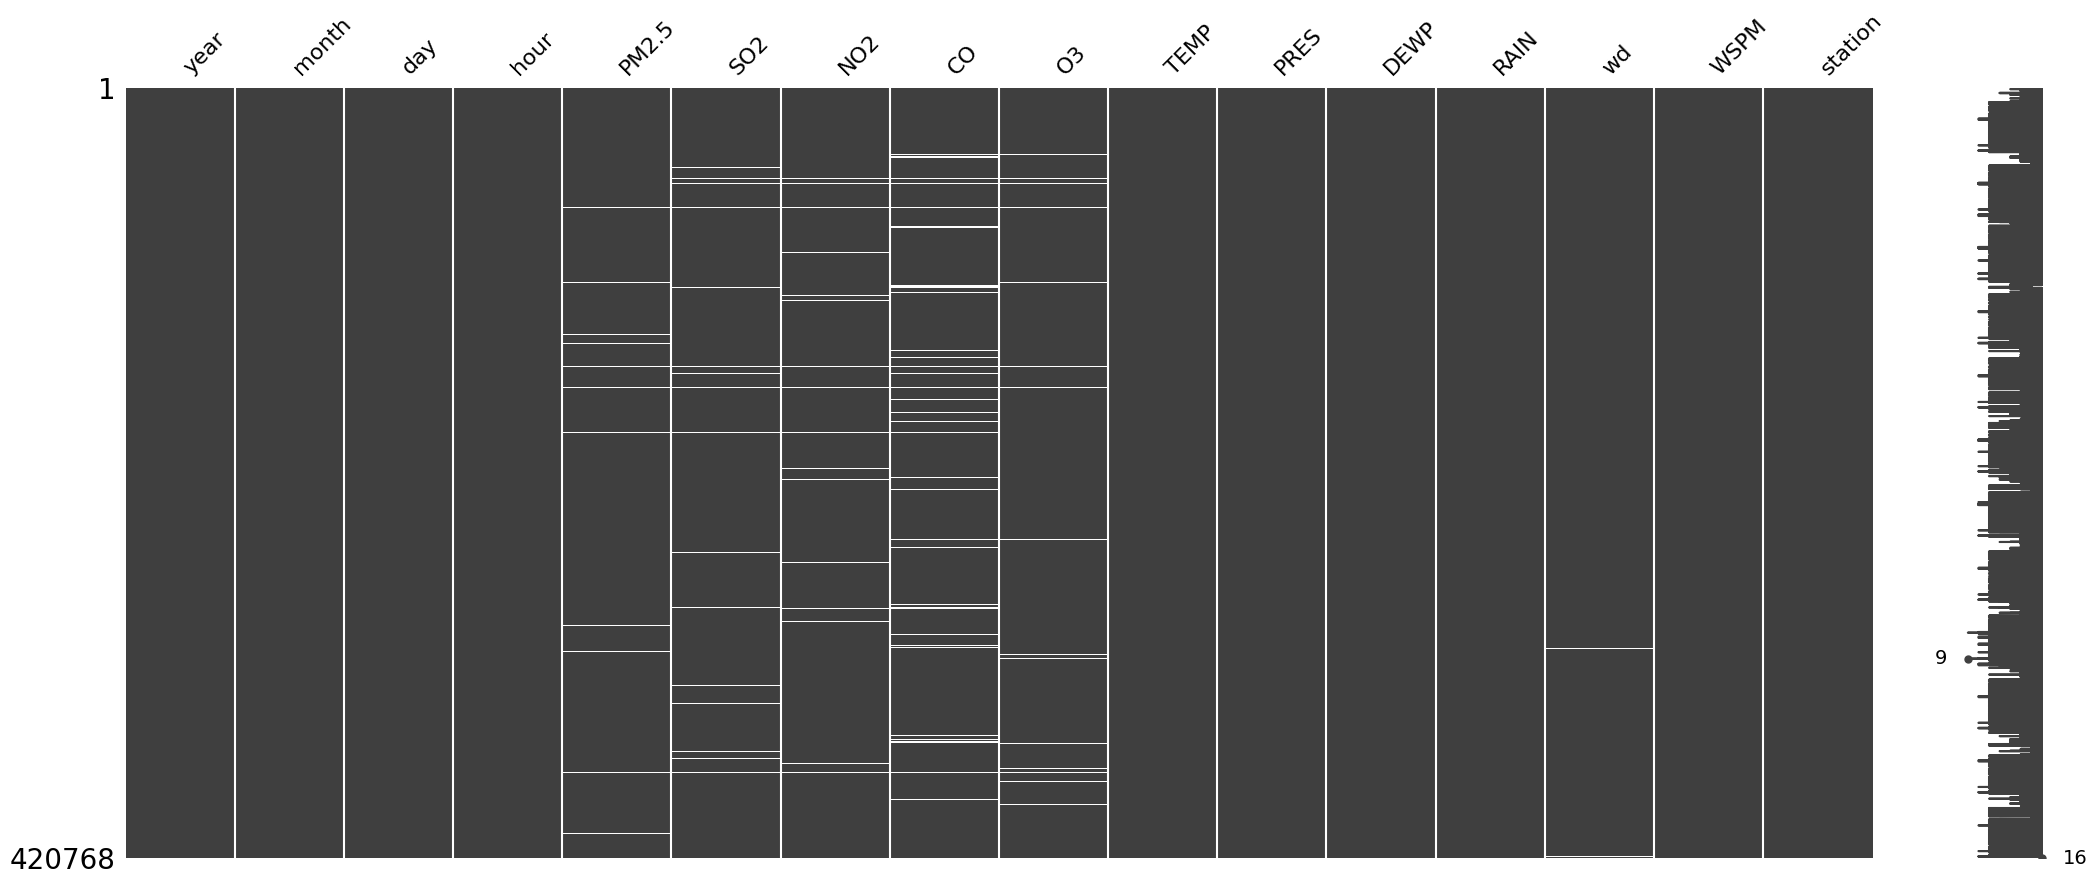

In [11]:
msno.matrix(df)

In [12]:
df["station"].unique()

array(['Aotizhongxin', 'Changping', 'Dingling', 'Dongsi', 'Guanyuan',
       'Gucheng', 'Huairou', 'Nongzhanguan', 'Shunyi', 'Tiantan',
       'Wanliu', 'Wanshouxigong'], dtype=object)

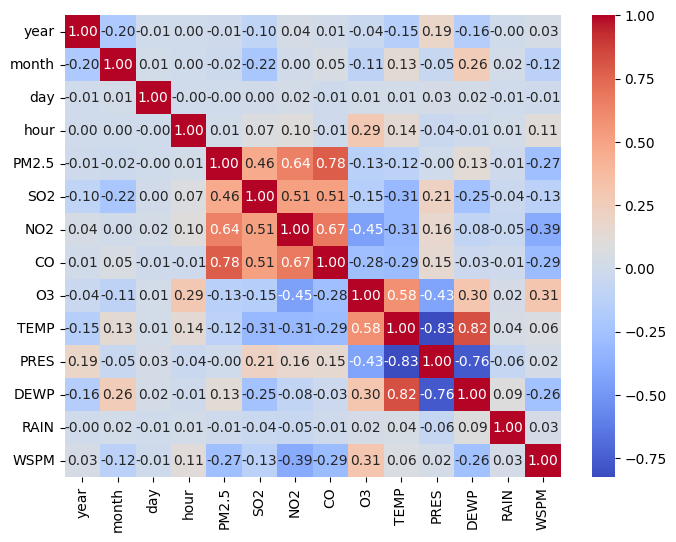

In [14]:
one_station = df[df["station"] == "Shunyi"]
df_station = one_station.drop(["wd", "station"], axis = 1)
corr_station = df_station.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_station, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

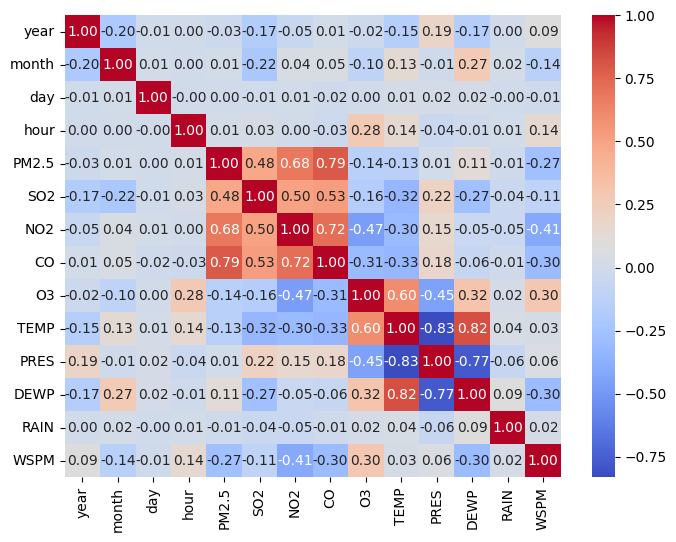

In [ ]:
corrs = []
for st, g in df.groupby("station"):
    corrs.append(g.drop(columns=["wd","station"]).corr())

mean_corr = sum(corrs) / len(corrs)
mean_corr

plt.figure(figsize=(8,6))
sns.heatmap(mean_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

### Modify to loop through each station

In [15]:
def t_test(group_vector1, group_vector2):
    equal_var_=np.var(group_vector1,ddof=1)==np.var(group_vector2,ddof=1)
    res=stats.ttest_ind(group_vector1,group_vector2, equal_var=equal_var_)
    return res

### Change the loop to loop through stations

In [ ]:
def diagnose_mv(df, mv_column):
    df_no_null = df[df[mv_column].notnull()]
    df_is_null = df[df[mv_column].isnull()]
    for col in df.columns:
        sAll = pd.to_numeric(df[col], errors='coerce')
        sNonnull = pd.to_numeric(df_no_null[col].dropna(), errors='coerce')
        missing= pd.to_numeric(df_is_null[col].dropna(), errors='coerce')
        results, p = t_test(sNonnull,missing)
        print("mcar" if p > 0.5 else "not mcar")
        if pd.api.types.is_numeric_dtype(df[col]):

            bins = np.histogram_bin_edges(sAll.dropna())

            countsAll, _  = np.histogram(sAll,    bins=bins)
            countsNonnull, _ = np.histogram(sNonnull, bins=bins)
            diff = np.abs(countsAll - countsNonnull)
            missingness = diff/countsAll
            data=np.vstack([diff, countsNonnull]).T
            '''
            if col != mv_column:
                chi2, p, dof, expected = chi2_contingency(data)
                print("Chi2 statistic:", chi2)
                print("degree of freedom: ",dof)
                print("p-value:", p)
            ''' 
            print(missingness*100)
            # plot
            fig, axes = plt.subplots(1, 3, figsize=(8, 2))

            bin_centers = 0.5 * (bins[1:] + bins[:-1])
            bin_widths  = np.diff(bins)

            axes[0].hist(sAll,    bins=bins)
            axes[1].hist(sNonnull.dropna(), bins=bins)
            axes[2].bar(bin_centers, diff, width=bin_widths, alpha=0.3, align='center')

            for ax in axes:
                ax.set_xticks(bin_centers)
                ax.set_xticklabels(bin_centers.astype(int))

            axes[0].set_title(f"{col} — all")
            axes[1].set_title(f"{col} — without MV")
            axes[2].set_title("|Δ count| per bin")
            plt.tight_layout()
            plt.show()

        else:

            vc_all = df[col].value_counts(dropna=False) #seriese of bin counts
            vc_non = df_no_null[col].value_counts(dropna=False)

            # align categories incase one category have no values, so diff do not return error
            cats = vc_all.index.union(vc_non.index) #
            c_all = vc_all.reindex(cats, fill_value=0)
            c_non = vc_non.reindex(cats, fill_value=0)
            diff = (c_all - c_non).abs()
            missingness= diff/c_all
            '''
            data=np.vstack([diff, c_non]).T
            if col != mv_column:
                chi2, p, dof, expected = chi2_contingency(data)
                print("Chi2 statistic:", chi2)
                print("degree of freedom: ",dof)
                print("p-value:", p)
            '''
            print("missingness ",missingness*100)
            x = np.arange(len(cats)) # number of categories/ bins
           
            w = 0.8

            fig, axes = plt.subplots(1, 3, figsize=(8, 2))

            axes[0].bar(x, c_all.values, width=w)
            axes[1].bar(x, c_non.values, width=w)
            axes[2].bar(x, diff.values,  width=w, alpha=0.3)


            for ax in axes:
                ax.set_xticks(x)
                ax.set_xticklabels(cats.astype(str), rotation=45, ha='right')

            axes[0].set_title(f"{col} — all")
            axes[1].set_title(f"{col} — without MV")
            axes[2].set_title("|Δ count| per category")
            plt.tight_layout()
            plt.show()



In [ ]:
diagnose_mv(df, 'PM2.5')

In [ ]:
diagnose_mv(df, 'SO2')

In [ ]:
diagnose_mv(df, 'NO2')

In [ ]:
diagnose_mv(df, 'CO')

In [ ]:
diagnose_mv(df, 'O3')

In [ ]:
diagnose_mv(df, 'TEMP')

In [ ]:
diagnose_mv(df, 'PRES')

In [ ]:
diagnose_mv(df, 'DEWP')

In [ ]:
diagnose_mv(df, 'RAIN')

In [ ]:
diagnose_mv(df, 'wd')

In [ ]:
diagnose_mv(df, 'WSPM')